<a href="https://colab.research.google.com/github/denizbariscan/DSA210-Term-Project/blob/main/data%20visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
import numpy as np
from datetime import datetime
import re
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
#Data Cleaning
htfile = '/content/drive/MyDrive/dsa/Hilltown Ürün Çıkış Raporu 8 Ekim - 10 Nisan.xlsx'
balcovafile = "/content/drive/MyDrive/dsa/urun-cikis-raporu-1744210116 (1).xlsx"
hilltown_df = pd.read_excel(htfile)
balcova_df = pd.read_excel(balcovafile)
# 1.Clean the spaces in column names
hilltown_df.columns = hilltown_df.columns.str.strip()
balcova_df.columns = balcova_df.columns.str.strip()
# 2.Normalize product names: turn to lower case, clean spaces and "_" at the beginning
hilltown_df["Ürün Adı"] = hilltown_df["Ürün Adı"].astype(str).str.strip().str.lower().str.lstrip("_")
balcova_df["Ürün Adı"] = balcova_df["Ürün Adı"].astype(str).str.strip().str.lower().str.lstrip("_")
# 3.Make empty strings NaN
hilltown_df.replace("", np.nan, inplace=True)
balcova_df.replace("", np.nan, inplace=True)
# 4.Eksik Tutar verilerini çıkar
hilltown_df = hilltown_df.dropna(subset=["Tutar"])
balcova_df = balcova_df.dropna(subset=["Tutar"])
# 5.Turn "Tutar" columns to numeric
hilltown_df["Tutar"] = pd.to_numeric(hilltown_df["Tutar"], errors="coerce")
balcova_df["Tutar"] = pd.to_numeric(balcova_df["Tutar"], errors="coerce")
# 6.Delete repeated rows
hilltown_df = hilltown_df.drop_duplicates()
balcova_df = balcova_df.drop_duplicates()
# 7.Remove 0 and negatives
hilltown_df = hilltown_df[hilltown_df["Tutar"] > 0]
balcova_df = balcova_df[balcova_df["Tutar"] > 0]
#Find common products
common_products = set(hilltown_df["Ürün Adı"]).intersection(set(balcova_df["Ürün Adı"]))
ht_common = hilltown_df[hilltown_df["Ürün Adı"].isin(common_products)].copy()
bal_common = balcova_df[balcova_df["Ürün Adı"].isin(common_products)].copy()

ht_summary = ht_common.groupby("Ürün Adı").agg({
    "Tutar": "sum",
    "Adet": "sum"
}).rename(columns={"Tutar": "Hilltown Toplam Tutar", "Adet": "Hilltown Satış Miktarı"})

bal_summary = bal_common.groupby("Ürün Adı").agg({
    "Tutar": "sum",
    "Adet": "sum"
}).rename(columns={"Tutar": "Balçova Toplam Tutar", "Adet": "Balçova Satış Miktarı"})
#Merge
merged_sales = pd.merge(ht_summary, bal_summary, left_index=True, right_index=True)
#Calculate average
merged_sales["Hilltown Ortalama Fiyat"] = merged_sales["Hilltown Toplam Tutar"] / merged_sales["Hilltown Satış Miktarı"]
merged_sales["Balçova Ortalama Fiyat"] = merged_sales["Balçova Toplam Tutar"] / merged_sales["Balçova Satış Miktarı"]
#Take the difference
merged_sales["Fiyat Farkı (Hilltown - Balçova)"] = merged_sales["Hilltown Ortalama Fiyat"] - merged_sales["Balçova Ortalama Fiyat"]
merged_sales["Satış Miktarı Farkı (Hilltown - Balçova)"] = merged_sales["Hilltown Satış Miktarı"] - merged_sales["Balçova Satış Miktarı"]
#Organize the table
final_table = merged_sales.reset_index()[[
    "Ürün Adı",
    "Hilltown Ortalama Fiyat",
    "Balçova Ortalama Fiyat",
    "Fiyat Farkı (Hilltown - Balçova)",
    "Hilltown Satış Miktarı",
    "Balçova Satış Miktarı",
    "Satış Miktarı Farkı (Hilltown - Balçova)"
]]
#Order in descending based on total sales quantity
final_table = final_table.sort_values(by="Hilltown Satış Miktarı", ascending=False).reset_index(drop=True)
#Roll numbers to closest integer
cols_to_round = ["Hilltown Ortalama Fiyat", "Balçova Ortalama Fiyat", "Fiyat Farkı (Hilltown - Balçova)"]
final_table[cols_to_round] = final_table[cols_to_round].round(0).astype("Int64")
output_path = "/content/drive/MyDrive/dsa/karşılaştırma tablosu.xlsx"
final_table.to_excel(output_path, index=False)
final_table.head(20)


,Ürün Adı,Hilltown Ortalama Fiyat,Balçova Ortalama Fiyat,Fiyat Farkı (Hilltown - Balçova),Hilltown Satış Miktarı,Balçova Satış Miktarı,Satış Miktarı Farkı (Hilltown - Balçova)
0,coca cola - şişe,66,57,8,14583,1639,12944
1,ohannes cheese burger,313,303,10,6590,3287,3303
2,ayran kutu,54,42,12,5314,1256,4058
3,regular cheese burger,279,119,160,4435,1865,2570
4,regular classic burger,197,71,126,4202,2245,1957
5,su - şişe,37,30,7,3741,472,3269
6,ohannes classic burger,250,280,-30,3687,1347,2340
7,carlsberg 50 ml,190,120,70,3419,411,3008
8,coca cola zero - şişe,68,58,10,3305,684,2621
9,ohannes mushroom burger,315,298,17,3159,1794,1365


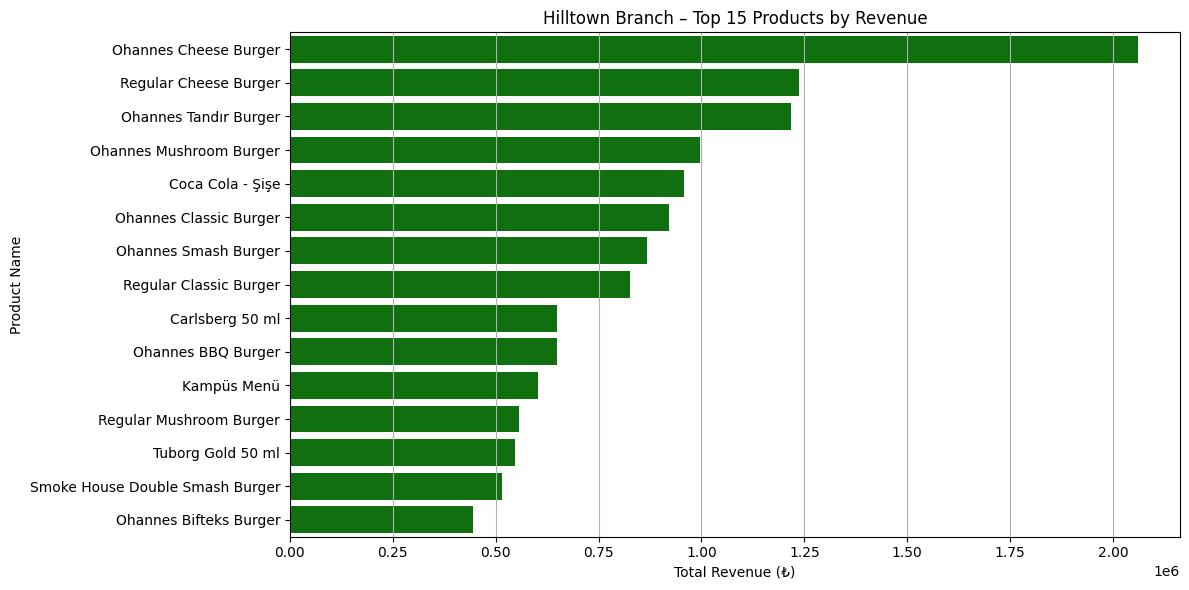

In [85]:
hilltown_df = pd.read_excel(htfile)
top15hilltownrevenue = hilltown_df.sort_values(by='Tutar', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=top15hilltownrevenue, x='Tutar', y='Ürün Adı', color='green')
plt.title("Hilltown Branch – Top 15 Products by Revenue")
plt.xlabel("Total Revenue (₺)")
plt.ylabel("Product Name")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


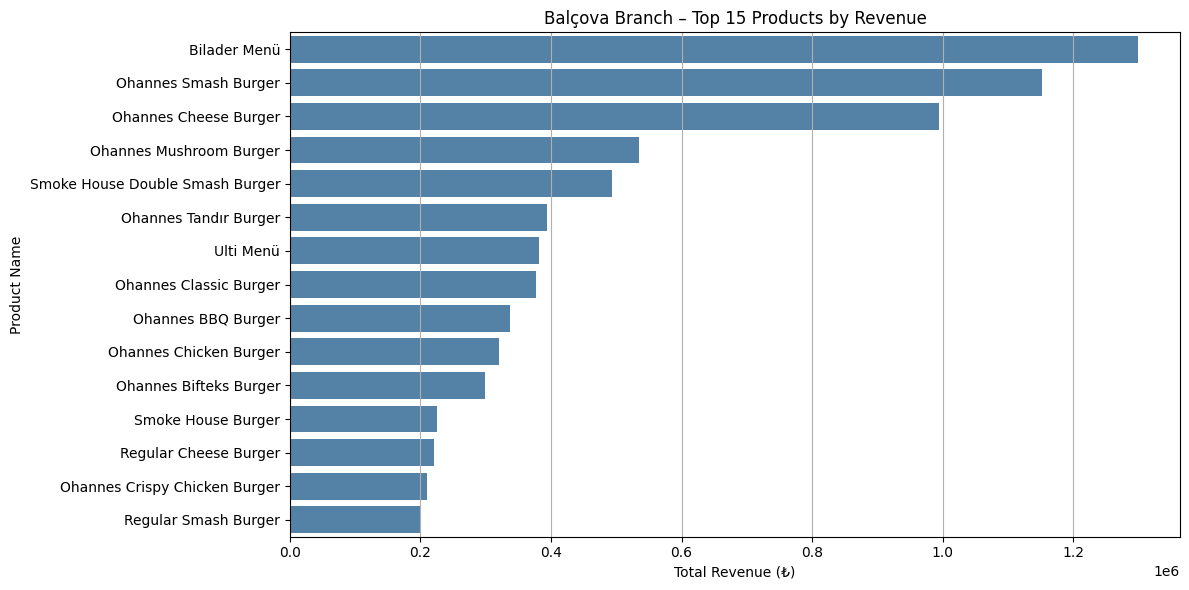

In [86]:
balcova_df = pd.read_excel(balcovafile)
top15balcovarevenue = balcova_df.sort_values(by='Tutar', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=top15balcovarevenue, x='Tutar', y='Ürün Adı', color='steelblue')
plt.title("Balçova Branch – Top 15 Products by Revenue")
plt.xlabel("Total Revenue (₺)")
plt.ylabel("Product Name")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [87]:
data = [
    {"Month": "October", "Total Revenue": 3_237_584.80, "Number of Days": 31},
    {"Month": "November", "Total Revenue": 3_228_013.60, "Number of Days": 30},
    {"Month": "December", "Total Revenue": 3_296_657.73, "Number of Days": 31},
    {"Month": "January", "Total Revenue": 3_495_294.48, "Number of Days": 31},
    {"Month": "February", "Total Revenue": 2_725_767.42, "Number of Days": 28},
    {"Month": "March", "Total Revenue": 3_464_407.50, "Number of Days": 31},
    {"Month": "April", "Total Revenue": 3_211_515.63, "Number of Days": 24}
]
df = pd.DataFrame(data)
df["Average Daily Revenue"] = (df["Total Revenue"] / df["Number of Days"]).round(2)
df.to_excel("/content/drive/MyDrive/dsa/hiltown daily revenue.xlsx", index=False)
print(df)

      Month  Total Revenue  Number of Days  Average Daily Revenue
0   October     3237584.80              31              104438.22
1  November     3228013.60              30              107600.45
2  December     3296657.73              31              106343.80
3   January     3495294.48              31              112751.43
4  February     2725767.42              28               97348.84
5     March     3464407.50              31              111755.08
6     April     3211515.63              24              133813.15


In [88]:
data = [
    {"Month": "October", "Total Revenue": 848_267.60, "Number of Days": 31},
    {"Month": "November", "Total Revenue": 1_258_737.80, "Number of Days": 30},
    {"Month": "December", "Total Revenue": 1_565_782.00, "Number of Days": 31},
    {"Month": "January", "Total Revenue": 1_831_322.35, "Number of Days": 31},
    {"Month": "February", "Total Revenue": 1_675_118.05, "Number of Days": 28},
    {"Month": "March", "Total Revenue": 2_157_938.25, "Number of Days": 31},
    {"Month": "April", "Total Revenue": 1_918_506.87, "Number of Days": 22}
]
df = pd.DataFrame(data)
df["Average Daily Revenue"] = (df["Total Revenue"] / df["Number of Days"]).round(2)
df.to_excel("/content/drive/MyDrive/dsa/balcova daily revenue.xlsx", index=False)
print(df)


      Month  Total Revenue  Number of Days  Average Daily Revenue
0   October      848267.60              31               27363.47
1  November     1258737.80              30               41957.93
2  December     1565782.00              31               50509.10
3   January     1831322.35              31               59074.91
4  February     1675118.05              28               59825.64
5     March     2157938.25              31               69610.91
6     April     1918506.87              22               87204.86


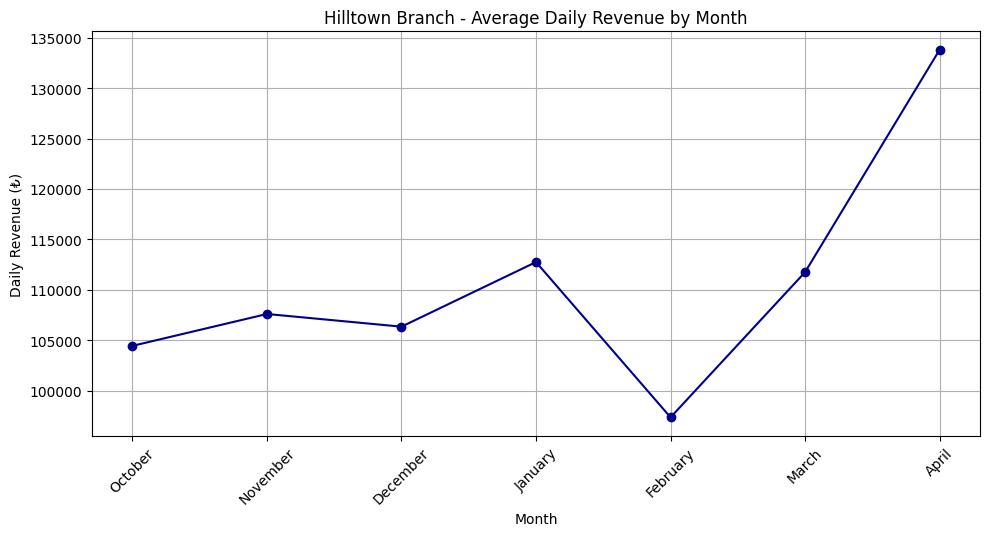

In [89]:
htdaily = '/content/drive/MyDrive/dsa/hiltown daily revenue.xlsx'
df = pd.read_excel(htdaily)
valid_months = ["October", "November", "December", "January", "February", "March", "April"]
df["Month"] = df["Month"].astype(str).str.strip()
df = df[df["Month"].isin(valid_months)]
df["Month"] = pd.Categorical(df["Month"], categories=valid_months, ordered=True)
df = df.sort_values("Month")
plt.figure(figsize=(10, 5))
plt.plot(df["Month"], df["Average Daily Revenue"], marker='o', color='darkblue')
plt.title("Hilltown Branch - Average Daily Revenue by Month")
plt.xlabel("Month")
plt.ylabel("Daily Revenue (₺)")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


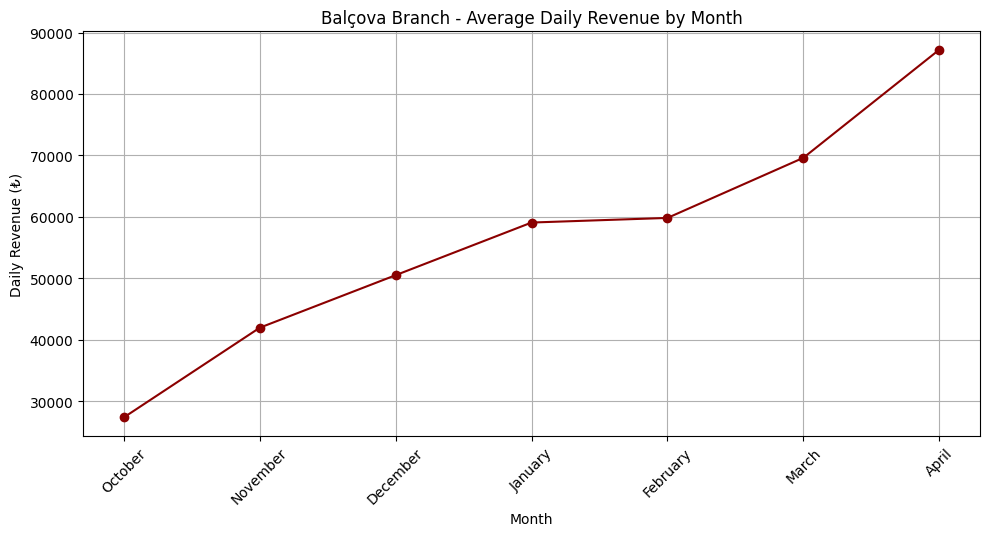

In [90]:
balcovadaily ='/content/drive/MyDrive/dsa/balcova daily revenue.xlsx'
df = pd.read_excel(balcovadaily)
valid_months = ["October", "November", "December", "January", "February", "March", "April"]
df["Month"] = df["Month"].astype(str).str.strip()
df = df[df["Month"].isin(valid_months)]
df["Month"] = pd.Categorical(df["Month"], categories=valid_months, ordered=True)
df = df.sort_values("Month")
plt.figure(figsize=(10, 5))
plt.plot(df["Month"], df["Average Daily Revenue"], marker='o', color='darkred')
plt.title("Balçova Branch - Average Daily Revenue by Month")
plt.xlabel("Month")
plt.ylabel("Daily Revenue (₺)")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


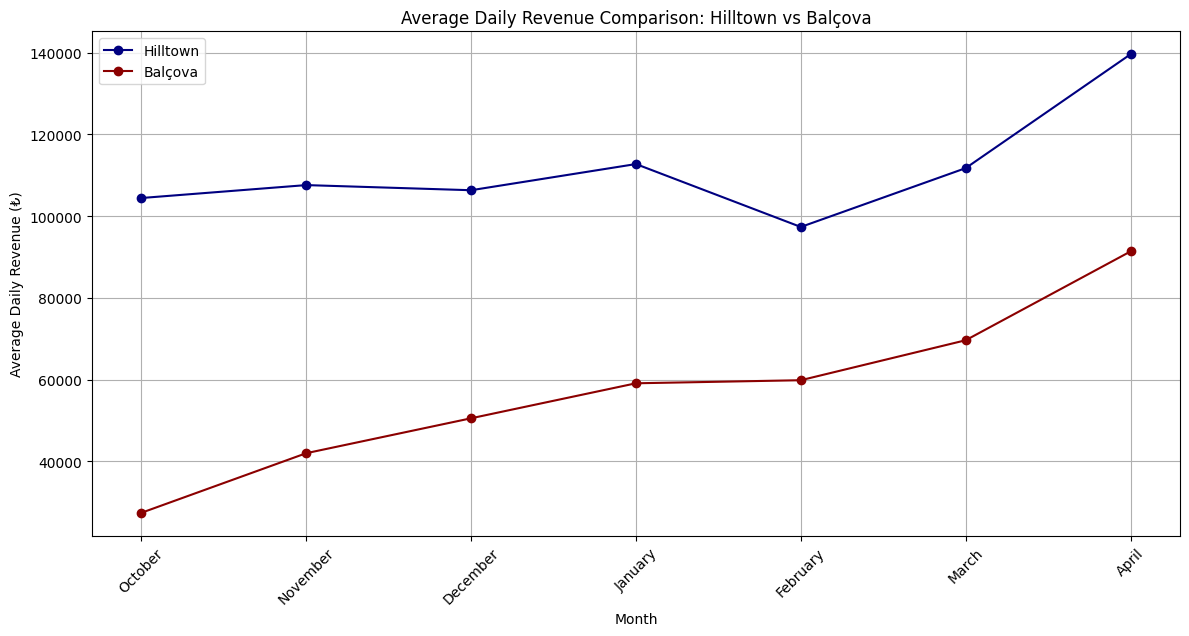

In [91]:
raw_data = [
    ("Hilltown", "Ekim", "01-10-2024 / 01-11-2024", "₺ 3,237,584.80"),
    ("Hilltown", "Kasım", "01-11-2024 / 01-12-2024", "₺ 3,228,013.60"),
    ("Hilltown", "Aralık", "01-12-2024 / 01-01-2025", "₺ 3,296,657.73"),
    ("Hilltown", "Ocak", "01-01-2025 / 01-02-2025", "₺ 3,495,294.48"),
    ("Hilltown", "Şubat", "01-02-2025 / 01-03-2025", "₺ 2,725,767.42"),
    ("Hilltown", "Mart", "01-03-2025 / 01-04-2025", "₺ 3,464,407.50"),
    ("Hilltown", "Nisan", "01-04-2025 / 24-04-2025", "₺ 3,211,515.63"),
    ("Balçova", "Ekim", "01-10-2024 / 01-11-2024", "₺ 848,267.60"),
    ("Balçova", "Kasım", "01-11-2024 / 01-12-2024", "₺ 1,258,737.80"),
    ("Balçova", "Aralık", "01-12-2024 / 01-01-2025", "₺ 1,565,782.00"),
    ("Balçova", "Ocak", "01-01-2025 / 01-02-2025", "₺ 1,831,322.35"),
    ("Balçova", "Şubat", "01-02-2025 / 01-03-2025", "₺ 1,675,118.05"),
    ("Balçova", "Mart", "01-03-2025 / 01-04-2025", "₺ 2,157,938.25"),
    ("Balçova", "Nisan", "01-04-2025 / 22-04-2025", "₺ 1,918,506.87")
]
ay_map = {
    "Ekim": "October", "Kasım": "November", "Aralık": "December",
    "Ocak": "January", "Şubat": "February", "Mart": "March", "Nisan": "April"
}
records = []
for sube, ay_tr, tarih_araligi, ciro_str in raw_data:
    ay_en = ay_map[ay_tr]
    baslangic_str, bitis_str = tarih_araligi.split(" / ")
    baslangic = datetime.strptime(baslangic_str, "%d-%m-%Y")
    bitis = datetime.strptime(bitis_str, "%d-%m-%Y")
    gun_sayisi = (bitis - baslangic).days
    ciro = float(re.sub(r"[₺,\s]", "", ciro_str))
    ort_ciro = round(ciro / gun_sayisi, 2)
    records.append({
        "Branch": sube,
        "Month": ay_en,
        "Average Daily Revenue": ort_ciro
    })
df = pd.DataFrame(records)
month_order = ["October", "November", "December", "January", "February", "March", "April"]
df["Month"] = pd.Categorical(df["Month"], categories=month_order, ordered=True)
df = df.sort_values(["Branch", "Month"])
hilltown_df = df[df["Branch"] == "Hilltown"]
balcova_df = df[df["Branch"] == "Balçova"]

plt.figure(figsize=(12, 6))
plt.plot(hilltown_df["Month"], hilltown_df["Average Daily Revenue"], marker='o', label="Hilltown", color='navy')
plt.plot(balcova_df["Month"], balcova_df["Average Daily Revenue"], marker='o', label="Balçova", color='darkred')
plt.title("Average Daily Revenue Comparison: Hilltown vs Balçova")
plt.xlabel("Month")
plt.ylabel("Average Daily Revenue (₺)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


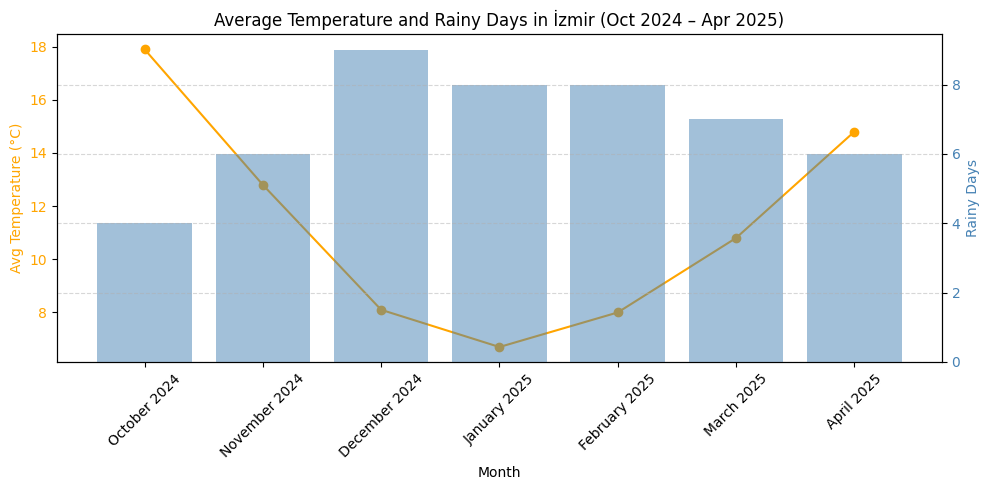

In [92]:
weatherdata = {
    "Month": ["October 2024", "November 2024", "December 2024",
              "January 2025", "February 2025", "March 2025", "April 2025"],
    "Avg Temperature (°C)": [17.9, 12.8, 8.1, 6.7, 8.0, 10.8, 14.8],
    "Total Precipitation (mm)": [65, 100, 116, 112, 105, 84, 67],
    "Rainy Days": [4, 6, 9, 8, 8, 7, 6]
}

df_weather = pd.DataFrame(weatherdata)
x = np.arange(len(df_weather["Month"]))
fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'orange'
ax1.set_xlabel("Month")
ax1.set_ylabel("Avg Temperature (°C)", color=color)
ax1.plot(x, df_weather["Avg Temperature (°C)"], marker='o', color=color, label="Avg Temp")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(df_weather["Month"], rotation=45)
ax2 = ax1.twinx()
color = 'steelblue'
ax2.set_ylabel("Rainy Days", color=color)
ax2.bar(x, df_weather["Rainy Days"], alpha=0.5, color=color, label="Rainy Days")
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Average Temperature and Rainy Days in İzmir (Oct 2024 – Apr 2025)")
fig.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()


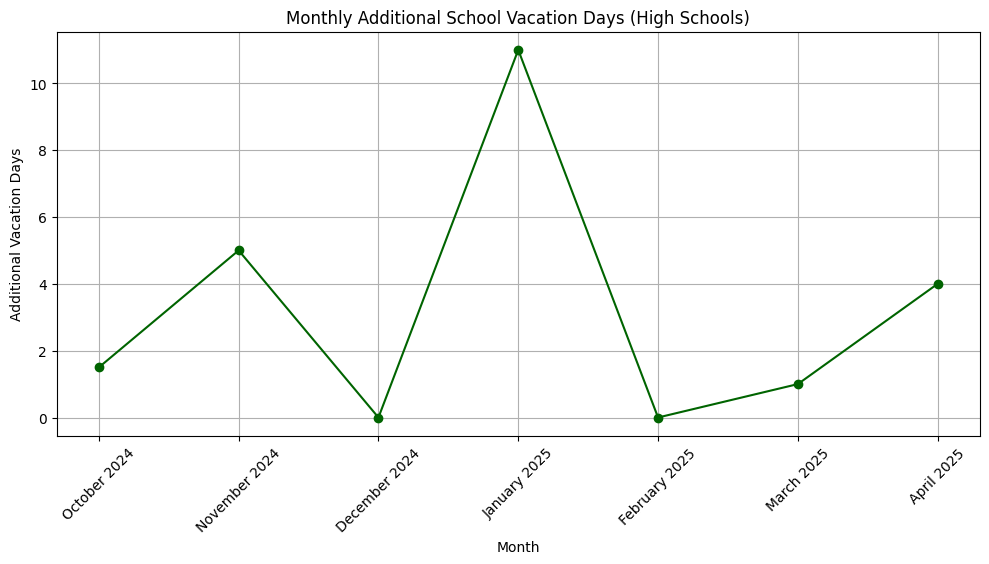

In [93]:

holiday = {
    "Month": ["October 2024", "November 2024", "December 2024",
              "January 2025", "February 2025", "March 2025", "April 2025"],
    "School Vacation Days (High Schools)": [1.5, 5, 0, 11, 0, 1, 4]
}
df_holidays = pd.DataFrame(holiday)
plt.figure(figsize=(10, 5))
plt.plot(df_holidays["Month"], df_holidays["School Vacation Days (High Schools)"], marker='o', color='darkgreen')
plt.title("Monthly Additional School Vacation Days (High Schools)")
plt.xlabel("Month")
plt.ylabel("Additional Vacation Days")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


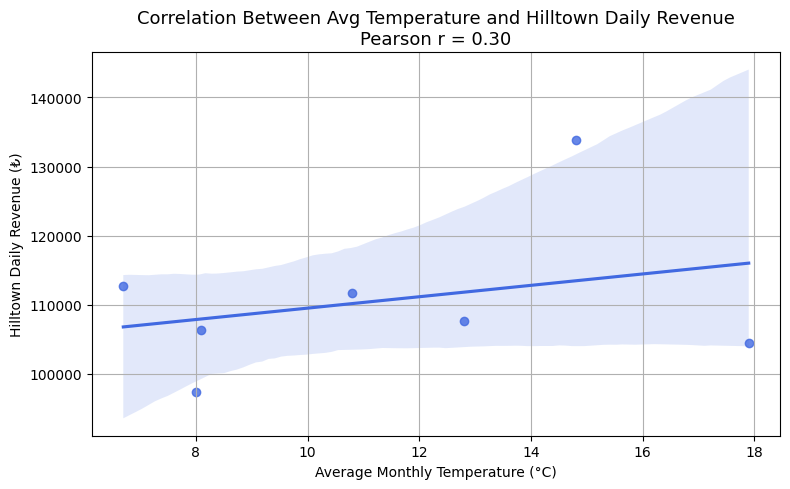

In [94]:
hilltown_df = pd.read_excel("/content/drive/MyDrive/dsa/hiltown daily revenue.xlsx").copy()
month_map = {
    "October": "October 2024", "November": "November 2024", "December": "December 2024",
    "January": "January 2025", "February": "February 2025", "March": "March 2025", "April": "April 2025"
}
hilltown_df["Month"] = hilltown_df["Month"].map(month_map)
df_weather = pd.DataFrame({
    "Month": ["October 2024", "November 2024", "December 2024",
              "January 2025", "February 2025", "March 2025", "April 2025"],
    "Avg Temperature (°C)": [17.9, 12.8, 8.1, 6.7, 8.0, 10.8, 14.8]
})
merged_df = pd.merge(df_weather, hilltown_df[["Month", "Average Daily Revenue"]], on="Month")
correlation, p_value = pearsonr(merged_df["Avg Temperature (°C)"], merged_df["Average Daily Revenue"])
plt.figure(figsize=(8, 5))
sns.regplot(x="Avg Temperature (°C)", y="Average Daily Revenue", data=merged_df, color="royalblue")
plt.title(f"Correlation Between Avg Temperature and Hilltown Daily Revenue\nPearson r = {correlation:.2f}", fontsize=13)
plt.xlabel("Average Monthly Temperature (°C)")
plt.ylabel("Hilltown Daily Revenue (₺)")
plt.grid(True)
plt.tight_layout()
plt.show()


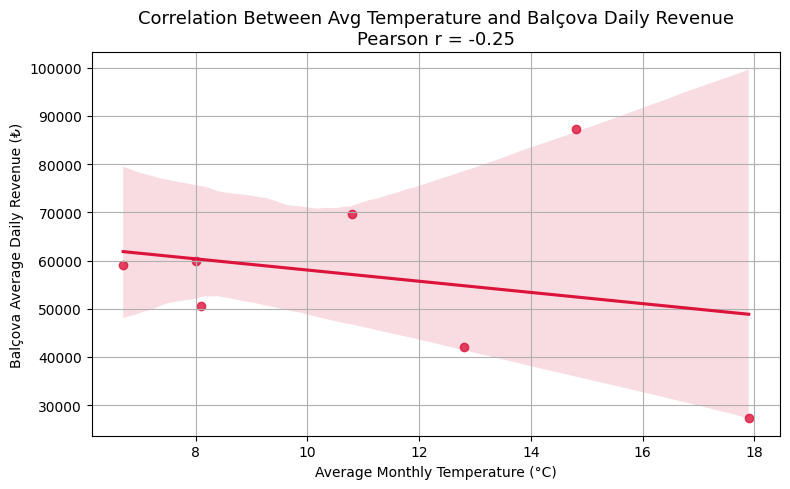

In [95]:
balcova_df = pd.read_excel("/content/drive/MyDrive/dsa/balcova daily revenue.xlsx").copy()
month_map = {
    "October": "October 2024", "November": "November 2024", "December": "December 2024",
    "January": "January 2025", "February": "February 2025", "March": "March 2025", "April": "April 2025"
}
balcova_df["Month"] = balcova_df["Month"].map(month_map)
df_weather = pd.DataFrame({
    "Month": ["October 2024", "November 2024", "December 2024",
              "January 2025", "February 2025", "March 2025", "April 2025"],
    "Avg Temperature (°C)": [17.9, 12.8, 8.1, 6.7, 8.0, 10.8, 14.8]
})
merged_balcova = pd.merge(df_weather, balcova_df[["Month", "Average Daily Revenue"]], on="Month")
correlation, p_value = pearsonr(merged_balcova["Avg Temperature (°C)"], merged_balcova["Average Daily Revenue"])
plt.figure(figsize=(8, 5))
sns.regplot(x="Avg Temperature (°C)", y="Average Daily Revenue", data=merged_balcova, color="crimson")
plt.title(f"Correlation Between Avg Temperature and Balçova Daily Revenue\nPearson r = {correlation:.2f}", fontsize=13)
plt.xlabel("Average Monthly Temperature (°C)")
plt.ylabel("Balçova Average Daily Revenue (₺)")
plt.grid(True)
plt.tight_layout()
plt.show()


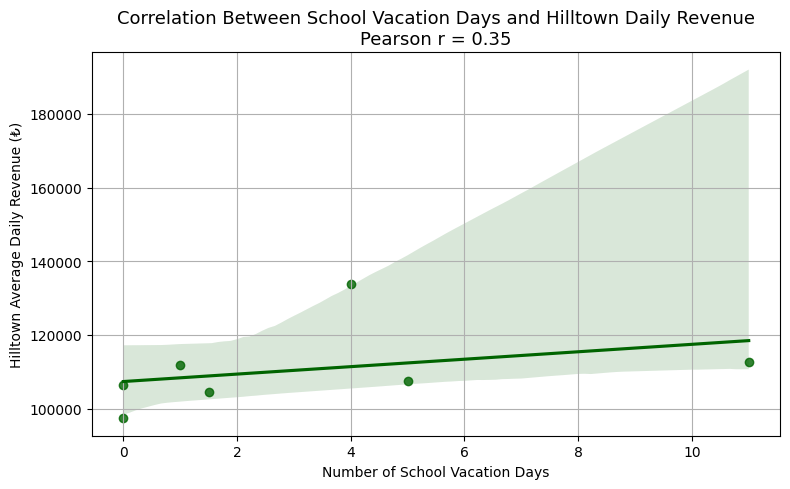

In [96]:
# 1. Read Hilltown revenue data directly from file
hilltown_df_clean = pd.read_excel("/content/drive/MyDrive/dsa/hiltown daily revenue.xlsx").copy()
# 2. Map months to full datetime format
month_map = {
    "October": "October 2024", "November": "November 2024", "December": "December 2024",
    "January": "January 2025", "February": "February 2025", "March": "March 2025", "April": "April 2025"
}
hilltown_df_clean["Month"] = hilltown_df_clean["Month"].map(month_map)
# 3. School vacation data
df_holidays = pd.DataFrame({
    "Month": ["October 2024", "November 2024", "December 2024",
              "January 2025", "February 2025", "March 2025", "April 2025"],
    "School Vacation Days": [1.5, 5, 0, 11, 0, 1, 4]
})
# 4. Merge datasets
merged_holiday_df = pd.merge(df_holidays, hilltown_df_clean[["Month", "Average Daily Revenue"]], on="Month")
correlation, p_value = pearsonr(merged_holiday_df["School Vacation Days"], merged_holiday_df["Average Daily Revenue"])
plt.figure(figsize=(8, 5))
sns.regplot(x="School Vacation Days", y="Average Daily Revenue", data=merged_holiday_df, color="darkgreen")
plt.title(f"Correlation Between School Vacation Days and Hilltown Daily Revenue\nPearson r = {correlation:.2f}", fontsize=13)
plt.xlabel("Number of School Vacation Days")
plt.ylabel("Hilltown Average Daily Revenue (₺)")
plt.grid(True)
plt.tight_layout()
plt.show()


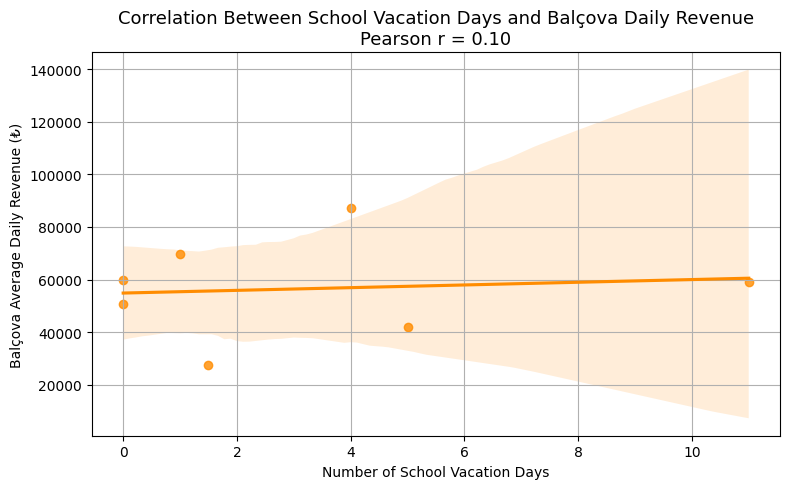

In [97]:
balcova_df_clean = pd.read_excel("/content/drive/MyDrive/dsa/balcova daily revenue.xlsx").copy()
month_map = {
    "October": "October 2024", "November": "November 2024", "December": "December 2024",
    "January": "January 2025", "February": "February 2025", "March": "March 2025", "April": "April 2025"
}
balcova_df_clean["Month"] = balcova_df_clean["Month"].map(month_map)
df_holidays = pd.DataFrame({
    "Month": ["October 2024", "November 2024", "December 2024",
              "January 2025", "February 2025", "March 2025", "April 2025"],
    "School Vacation Days": [1.5, 5, 0, 11, 0, 1, 4]
})
merged_df = pd.merge(df_holidays, balcova_df_clean[["Month", "Average Daily Revenue"]], on="Month")
correlation, p_value = pearsonr(merged_df["School Vacation Days"], merged_df["Average Daily Revenue"])
plt.figure(figsize=(8, 5))
sns.regplot(x="School Vacation Days", y="Average Daily Revenue", data=merged_df, color="darkorange")
plt.title(f"Correlation Between School Vacation Days and Balçova Daily Revenue\nPearson r = {correlation:.2f}", fontsize=13)
plt.xlabel("Number of School Vacation Days")
plt.ylabel("Balçova Average Daily Revenue (₺)")
plt.grid(True)
plt.tight_layout()
plt.show()


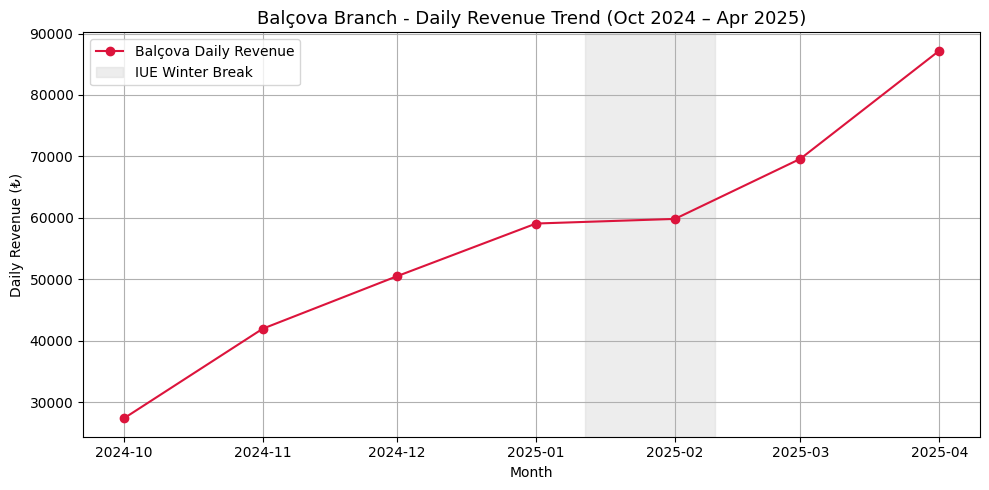

In [98]:
balcova_df = pd.read_excel("/content/drive/MyDrive/dsa/balcova daily revenue.xlsx").copy()
month_to_date = {
    "October": "2024-10-01",
    "November": "2024-11-01",
    "December": "2024-12-01",
    "January": "2025-01-01",
    "February": "2025-02-01",
    "March": "2025-03-01",
    "April": "2025-04-01"
}
balcova_df["Date"] = pd.to_datetime(balcova_df["Month"].map(month_to_date))
balcova_df = balcova_df.sort_values("Date")
plt.figure(figsize=(10, 5))
plt.plot(balcova_df["Date"], balcova_df["Average Daily Revenue"], marker='o', color='crimson', label="Balçova Daily Revenue")
plt.title("Balçova Branch - Daily Revenue Trend (Oct 2024 – Apr 2025)", fontsize=13)
plt.xlabel("Month")
plt.ylabel("Daily Revenue (₺)")
plt.grid(True)
plt.axvspan(pd.to_datetime("2025-01-12"), pd.to_datetime("2025-02-10"),
            color='lightgrey', alpha=0.4, label="IUE Winter Break")

plt.legend()
plt.tight_layout()
plt.show()


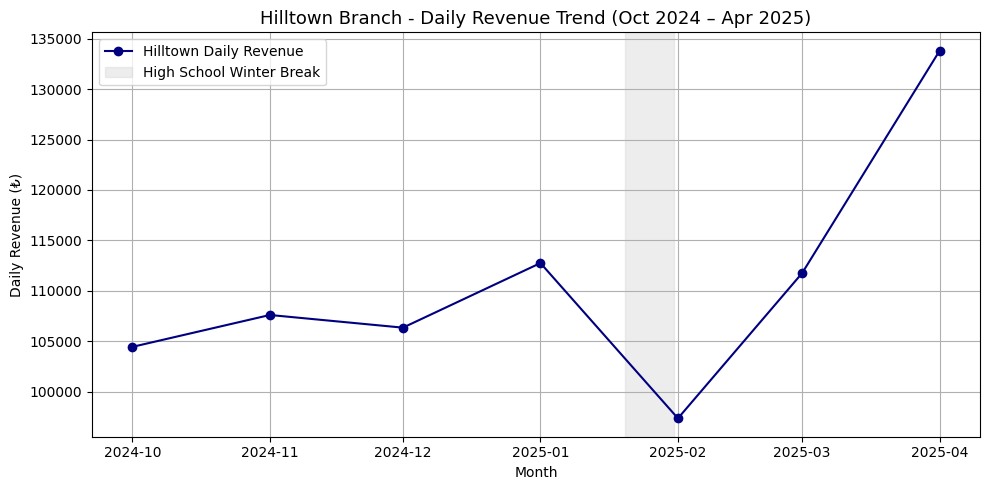

In [99]:
hilltown_df = pd.read_excel("/content/drive/MyDrive/dsa/hiltown daily revenue.xlsx").copy()
month_to_date = {
    "October": "2024-10-01",
    "November": "2024-11-01",
    "December": "2024-12-01",
    "January": "2025-01-01",
    "February": "2025-02-01",
    "March": "2025-03-01",
    "April": "2025-04-01"
}
hilltown_df["Date"] = pd.to_datetime(hilltown_df["Month"].map(month_to_date))
hilltown_df = hilltown_df.sort_values("Date")
plt.figure(figsize=(10, 5))
plt.plot(hilltown_df["Date"], hilltown_df["Average Daily Revenue"], marker='o', color='navy', label="Hilltown Daily Revenue")
plt.title("Hilltown Branch - Daily Revenue Trend (Oct 2024 – Apr 2025)", fontsize=13)
plt.xlabel("Month")
plt.ylabel("Daily Revenue (₺)")
plt.grid(True)
plt.axvspan(pd.to_datetime("2025-01-20"), pd.to_datetime("2025-01-31"),
            color='lightgrey', alpha=0.4, label="High School Winter Break")

plt.legend()
plt.tight_layout()
plt.show()


In [100]:
ht_df = pd.read_excel("/content/drive/MyDrive/dsa/hiltown daily revenue.xlsx")
bal_df = pd.read_excel("/content/drive/MyDrive/dsa/balcova daily revenue.xlsx")

valid_months = ["October", "November", "December", "January", "February", "March", "April"]
rainy_days = [4, 6, 9, 8, 8, 7, 6]
ht_df["Month"] = pd.Categorical(ht_df["Month"].astype(str).str.strip(), categories=valid_months, ordered=True)
bal_df["Month"] = pd.Categorical(bal_df["Month"].astype(str).str.strip(), categories=valid_months, ordered=True)
ht_df = ht_df.sort_values("Month").reset_index(drop=True)
bal_df = bal_df.sort_values("Month").reset_index(drop=True)


r_ht, _ = pearsonr(rainy_days, ht_df["Average Daily Revenue"])
r_balcova, _ = pearsonr(rainy_days, bal_df["Average Daily Revenue"])


z_ht = 0.5 * np.log((1 + r_ht) / (1 - r_ht))
z_balcova = 0.5 * np.log((1 + r_balcova) / (1 - r_balcova))
n = 7

z_score = (z_ht - z_balcova) / np.sqrt(1/(n - 3) + 1/(n - 3))
print(f"Pearson r (Hilltown) = {r_ht:.2f}")
print(f"Pearson r (Balçova)  = {r_balcova:.2f}")
print(f"Fisher Z-score       = {z_score:.2f}")

if abs(z_score) > 1.96:
    print("Reject H₀: Rainy weather effects on sales differ significantly between branches.")
else:
    print("Fail to Reject H₀: Rainy weather effects on sales do not differ significantly between branches.")


Pearson r (Hilltown) = -0.19
Pearson r (Balçova)  = 0.34
Fisher Z-score       = -0.76
Fail to Reject H₀: Rainy weather effects on sales do not differ significantly between branches.


Pearson Correlation Test Results
-----------------------------------
Correlation coefficient: -0.0952
p-value: 0.2773
Fail to Reject H₀: There is no significant relationship between the price difference and sales quantity between the two branches.


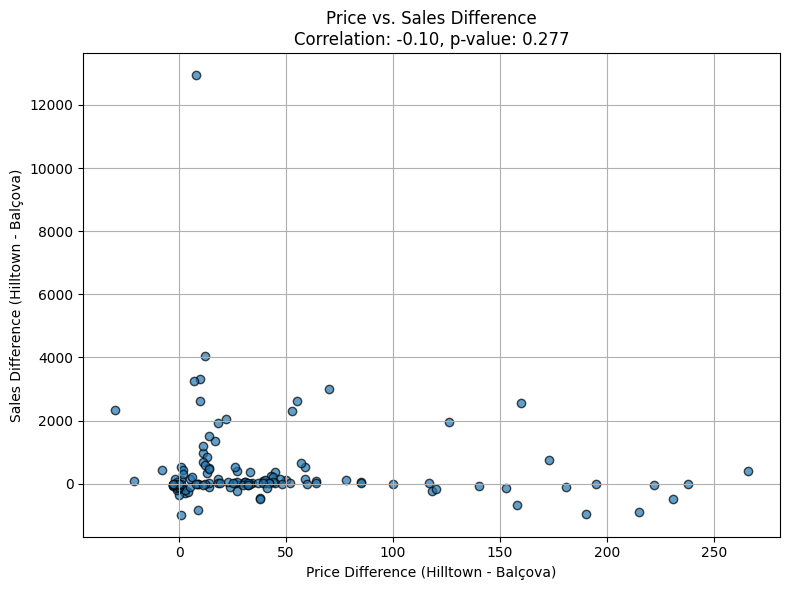

In [101]:
file_path = "/content/drive/MyDrive/dsa/karşılaştırma tablosu.xlsx"
df = pd.read_excel(file_path)

# 2. Clean NaN rows
df_clean = df.dropna(subset=["Fiyat Farkı (Hilltown - Balçova)", "Satış Miktarı Farkı (Hilltown - Balçova)"])

# 3. Choose the important columns
price_diff = df_clean["Fiyat Farkı (Hilltown - Balçova)"]
sales_diff = df_clean["Satış Miktarı Farkı (Hilltown - Balçova)"]
correlation, p_value = pearsonr(price_diff, sales_diff)
print("Pearson Correlation Test Results")
print("-----------------------------------")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"p-value: {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print("Reject H₀: There is a significant relationship between the price difference and sales quantity between the two branches.")
else:
    print("Fail to Reject H₀: There is no significant relationship between the price difference and sales quantity between the two branches.")

# 7. Grafik
plt.figure(figsize=(8, 6))
plt.scatter(price_diff, sales_diff, alpha=0.7, edgecolors='k')
plt.title(f'Price vs. Sales Difference\nCorrelation: {correlation:.2f}, p-value: {p_value:.3f}')
plt.xlabel('Price Difference (Hilltown - Balçova)')
plt.ylabel('Sales Difference (Hilltown - Balçova)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [103]:
file_path = "/content/drive/MyDrive/dsa/karşılaştırma tablosu.xlsx"
df = pd.read_excel(file_path)
def sales_outcome(diff):
    if diff > 0:
        return "Mall advantaged"
    elif diff < 0:
        return "University advantaged"
    else:
        return "Equal"

df["Sales Outcome"] = df["Satış Miktarı Farkı (Hilltown - Balçova)"].apply(sales_outcome)
df["Winning Location"] = df["Sales Outcome"].map({
    "Mall advantaged": "Mall",
    "University advantaged": "University",
    "Equal": "Equal"
})
contingency_table = pd.crosstab(df["Winning Location"], df["Sales Outcome"])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("Contingency Table:")
print(contingency_table)
print("\nChi-Square value:", round(chi2, 4))
print("Degrees of Freedom:", dof)
print("p-value:", round(p_value, 4))
alpha = 0.05
if p_value < alpha:
    print("Reject H₀: There is a significant relationship between the location type (mall vs. university area) and the sales advantage.")
else:
    print("Fail to Reject H₀: There is no significant relationship between the location type and the sales advantage.")


Contingency Table:
Sales Outcome     Mall advantaged  University advantaged
Winning Location                                        
Mall                           76                      0
University                      0                     56

Chi-Square value: 127.9378
Degrees of Freedom: 1
p-value: 0.0
Reject H₀: There is a significant relationship between the location type (mall vs. university area) and the sales advantage.
